# Task 1: Setting the Baseline 
## Task 1.1 Data Preparation and Validation Pipeline

In [78]:
import pandas as pd 
import numpy as np

df_raw_train = pd.read_csv("./kaggle/input/3bodyproblem/mlNOVA/mlNOVA/X_train.csv")
df_raw_test = pd.read_csv("./kaggle/input/3bodyproblem/mlNOVA/mlNOVA/X_test.csv")

### Visualize few trajectories

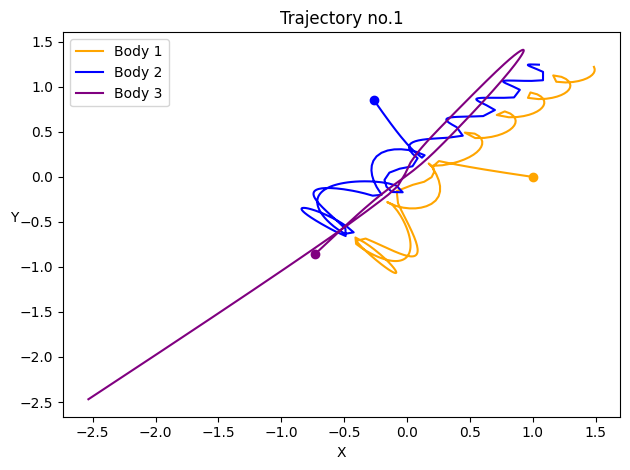

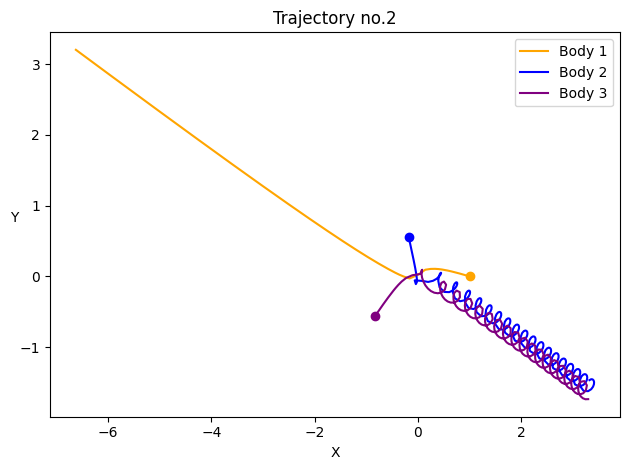

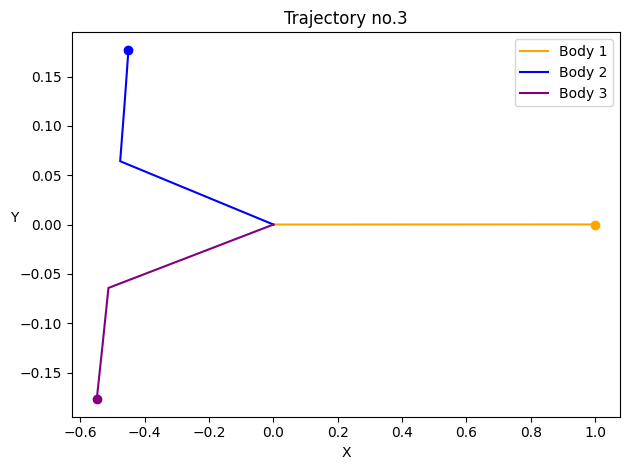

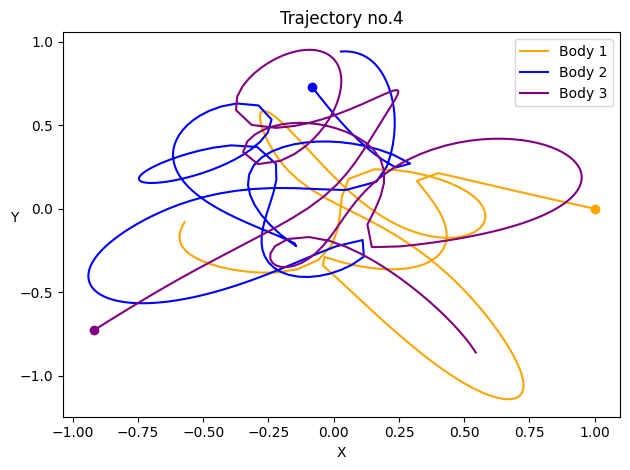

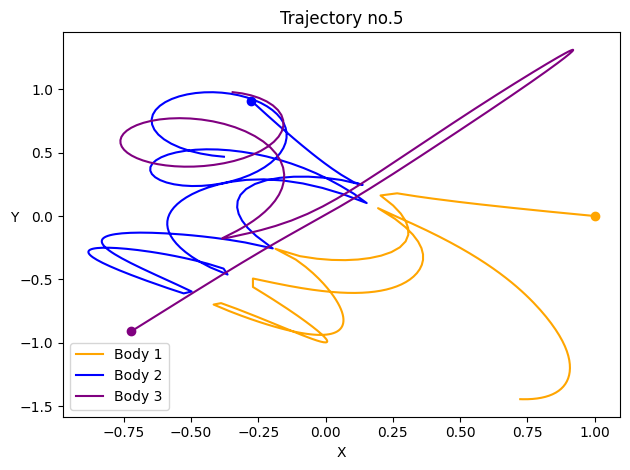

In [79]:
import matplotlib.pyplot as plt

start = 0
end = 257

for i in range(5):
    trajectory = df_raw_train[start:end]
    x1, y1, x2, y2, x3, y3 = trajectory.x_1, trajectory.y_1, trajectory.x_2, trajectory.y_2, trajectory.x_3, trajectory.y_3
    plt.plot(x1, y1, color="orange", label = "Body 1")
    plt.plot(x2, y2, color="blue", label = "Body 2")
    plt.plot(x3, y3, color="purple", label = "Body 3")
    plt.scatter(x1[start], y1[start], color="orange")
    plt.scatter(x2[start], y2[start], color="blue")
    plt.scatter(x3[start], y3[start], color="purple")
    plt.xlabel("X")
    plt.ylabel("Y", rotation=0)
    plt.title("Trajectory no." + str(i+1))
    plt.legend()
    plt.tight_layout()
    plt.show()

    start += 257
    end += 257


### Prepare the dataset

In [80]:
df_raw_train["group"] = df_raw_train["Id"]//257

In [81]:
#All starting positions
df_init = df_raw_train[ df_raw_train.index%257 == 0]

In [82]:
df_combined = df_raw_train.merge(df_init, on="group",  suffixes=('', '_init'))

# Step 1: Create a list/array of unique group_ids
unique_groups = df_combined['Id_init'].unique()

# Step 2: Create a random mask for this list
mask_train_test = np.random.rand(len(unique_groups)) < 0.8  # random True/False values

# Step 3: Split unique groups into two sets
group_train = unique_groups[mask_train_test]  # groups for the training set
group_testing = unique_groups[~mask_train_test]  # groups for the test set

# Step 4: Use the mask to split the DataFrame
train_set = df_combined[df_combined['Id_init'].isin(group_train)]
testing_set = df_combined[df_combined['Id_init'].isin(group_testing)]


unique_groups1 = testing_set['Id_init'].unique()

mask_val_test = np.random.rand(len(unique_groups1)) < 0.5

group_validation = unique_groups1[mask_val_test]  # groups for the training set
group_test = unique_groups1[~mask_val_test]  # groups for the test set

validation_set = testing_set[testing_set['Id_init'].isin(group_validation)]
test_set = testing_set[testing_set['Id_init'].isin(group_test)]



In [83]:
train_set

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id,group,t_init,x_1_init,y_1_init,v_x_1_init,v_y_1_init,x_2_init,y_2_init,v_x_2_init,v_y_2_init,x_3_init,y_3_init,v_x_3_init,v_y_3_init,Id_init
0,0.000000,1.000000,0.000000,0.000000,0.000000,-0.266467,0.859196,0.000000,0.000000,-0.733533,-0.859196,0.000000,0.000000,0,0,0.0,1.0,0.0,0.0,0.0,-0.266467,0.859196,0.0,0.0,-0.733533,-0.859196,0.0,0.0,0
1,0.039062,0.999548,0.000092,-0.023159,0.004731,-0.266261,0.858781,0.010574,-0.021257,-0.733287,-0.858874,0.012584,0.016526,1,0,0.0,1.0,0.0,0.0,0.0,-0.266467,0.859196,0.0,0.0,-0.733533,-0.859196,0.0,0.0,0
2,0.078125,0.998190,0.000370,-0.046362,0.009474,-0.265641,0.857535,0.021172,-0.042552,-0.732549,-0.857905,0.025189,0.033078,2,0,0.0,1.0,0.0,0.0,0.0,-0.266467,0.859196,0.0,0.0,-0.733533,-0.859196,0.0,0.0,0
3,0.117188,0.995925,0.000833,-0.069654,0.014239,-0.264606,0.855456,0.031817,-0.063924,-0.731318,-0.856289,0.037837,0.049685,3,0,0.0,1.0,0.0,0.0,0.0,-0.266467,0.859196,0.0,0.0,-0.733533,-0.859196,0.0,0.0,0
4,0.156250,0.992747,0.001483,-0.093080,0.019040,-0.263154,0.852540,0.042533,-0.085412,-0.729592,-0.854022,0.050548,0.066372,4,0,0.0,1.0,0.0,0.0,0.0,-0.266467,0.859196,0.0,0.0,-0.733533,-0.859196,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1284224,9.843750,0.431058,0.202489,-0.668326,-0.496782,-0.504008,0.599934,0.350354,0.004134,0.072950,-0.802423,0.317971,0.492649,1284224,4996,0.0,1.0,0.0,0.0,0.0,-0.219173,0.616222,0.0,0.0,-0.780827,-0.616222,0.0,0.0,1283972
1284225,9.882810,0.404034,0.182732,-0.715625,-0.514987,-0.489504,0.599484,0.392538,-0.027626,0.085471,-0.782216,0.323087,0.542613,1284225,4996,0.0,1.0,0.0,0.0,0.0,-0.219173,0.616222,0.0,0.0,-0.780827,-0.616222,0.0,0.0,1283972
1284226,9.921880,0.375123,0.162235,-0.764920,-0.534787,-0.473315,0.597739,0.436673,-0.062222,0.098192,-0.759974,0.328247,0.597008,1284226,4996,0.0,1.0,0.0,0.0,0.0,-0.219173,0.616222,0.0,0.0,-0.780827,-0.616222,0.0,0.0,1283972
1284227,9.960940,0.344247,0.140925,-0.816290,-0.556647,-0.455360,0.594578,0.483009,-0.100261,0.111113,-0.735503,0.333280,0.656908,1284227,4996,0.0,1.0,0.0,0.0,0.0,-0.219173,0.616222,0.0,0.0,-0.780827,-0.616222,0.0,0.0,1283972


In [84]:
validation_set

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id,group,t_init,x_1_init,y_1_init,v_x_1_init,v_y_1_init,x_2_init,y_2_init,v_x_2_init,v_y_2_init,x_3_init,y_3_init,v_x_3_init,v_y_3_init,Id_init
257,0.000000,1.000000,0.000000,0.000000,0.000000,-0.176502,0.555739,0.000000,0.000000,-0.823498,-0.555739,0.000000,0.000000,257,1,0.0,1.0,0.0,0.0,0.0,-0.176502,0.555739,0.0,0.0,-0.823498,-0.555739,0.0,0.0,257
258,0.039062,0.999392,0.000131,-0.031160,0.006723,-0.176326,0.555148,0.008985,-0.030279,-0.823065,-0.555279,0.022176,0.023556,258,1,0.0,1.0,0.0,0.0,0.0,-0.176502,0.555739,0.0,0.0,-0.823498,-0.555739,0.0,0.0,257
259,0.078125,0.997564,0.000525,-0.062415,0.013460,-0.175799,0.553372,0.017992,-0.060639,-0.821765,-0.553898,0.044423,0.047179,259,1,0.0,1.0,0.0,0.0,0.0,-0.176502,0.555739,0.0,0.0,-0.823498,-0.555739,0.0,0.0,257
260,0.117188,0.994513,0.001183,-0.093859,0.020224,-0.174920,0.550408,0.027043,-0.091163,-0.819593,-0.551591,0.066816,0.070939,260,1,0.0,1.0,0.0,0.0,0.0,-0.176502,0.555739,0.0,0.0,-0.823498,-0.555739,0.0,0.0,257
261,0.156250,0.990228,0.002106,-0.125591,0.027029,-0.173686,0.546247,0.036162,-0.121934,-0.816542,-0.548353,0.089430,0.094905,261,1,0.0,1.0,0.0,0.0,0.0,-0.176502,0.555739,0.0,0.0,-0.823498,-0.555739,0.0,0.0,257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1284995,9.843750,-0.022787,-0.354678,-1.450539,-0.511101,-0.128897,-0.618452,1.066492,-0.497032,0.151684,0.973131,0.384048,1.008133,1284995,4999,0.0,1.0,0.0,0.0,0.0,-0.300429,0.400142,0.0,0.0,-0.699571,-0.400142,0.0,0.0,1284743
1284996,9.882810,-0.082072,-0.384254,-1.556362,-1.038875,-0.084507,-0.627569,1.177829,0.065469,0.166578,1.011822,0.378533,0.973406,1284996,4999,0.0,1.0,0.0,0.0,0.0,-0.300429,0.400142,0.0,0.0,-0.699571,-0.400142,0.0,0.0,1284743
1284997,9.921880,-0.140434,-0.438907,-1.348462,-1.794786,-0.040823,-0.610311,0.975436,0.853069,0.181257,1.049218,0.373027,0.941717,1284997,4999,0.0,1.0,0.0,0.0,0.0,-0.300429,0.400142,0.0,0.0,-0.699571,-0.400142,0.0,0.0,1284743
1284998,9.960940,-0.177344,-0.524277,-0.380080,-2.492241,-0.018380,-0.561151,0.012292,1.579595,0.195724,1.085428,0.367788,0.912645,1284998,4999,0.0,1.0,0.0,0.0,0.0,-0.300429,0.400142,0.0,0.0,-0.699571,-0.400142,0.0,0.0,1284743


In [85]:
test_set

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id,group,t_init,x_1_init,y_1_init,v_x_1_init,v_y_1_init,x_2_init,y_2_init,v_x_2_init,v_y_2_init,x_3_init,y_3_init,v_x_3_init,v_y_3_init,Id_init
5654,0.000000,1.000000,0.000000,0.000000,0.000000,-0.176996,0.881883,0.000000,0.000000,-0.823004,-0.881883,0.000000,0.000000,5654,22,0.0,1.0,0.0,0.0,0.0,-0.176996,0.881883,0.0,0.0,-0.823004,-0.881883,0.0,0.0,5654
5655,0.039062,0.999550,0.000131,-0.023034,0.006684,-0.176788,0.881469,0.010649,-0.021231,-0.822762,-0.881599,0.012385,0.014548,5655,22,0.0,1.0,0.0,0.0,0.0,-0.176996,0.881883,0.0,0.0,-0.823004,-0.881883,0.0,0.0,5654
5656,0.078125,0.998200,0.000522,-0.046114,0.013385,-0.176164,0.880224,0.021325,-0.042501,-0.822036,-0.880747,0.024789,0.029116,5656,22,0.0,1.0,0.0,0.0,0.0,-0.176996,0.881883,0.0,0.0,-0.823004,-0.881883,0.0,0.0,5654
5657,0.117188,0.995946,0.001177,-0.069284,0.020121,-0.175122,0.878147,0.032053,-0.063847,-0.820825,-0.879324,0.037231,0.043727,5657,22,0.0,1.0,0.0,0.0,0.0,-0.176996,0.881883,0.0,0.0,-0.823004,-0.881883,0.0,0.0,5654
5658,0.156250,0.992785,0.002095,-0.092593,0.026909,-0.173659,0.875235,0.042863,-0.085310,-0.819126,-0.877330,0.049730,0.058401,5658,22,0.0,1.0,0.0,0.0,0.0,-0.176996,0.881883,0.0,0.0,-0.823004,-0.881883,0.0,0.0,5654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1284738,9.843750,-0.408051,-0.012284,1.189426,-0.815697,-0.424418,-0.404970,-0.307460,1.010425,0.832469,0.417254,-0.881966,-0.194728,1284738,4998,0.0,1.0,0.0,0.0,0.0,-0.098487,0.623007,0.0,0.0,-0.901513,-0.623007,0.0,0.0,1284486
1284739,9.882810,-0.361738,-0.049591,1.169348,-1.114156,-0.435557,-0.359714,-0.249920,1.326808,0.797296,0.409304,-0.919429,-0.212652,1284739,4998,0.0,1.0,0.0,0.0,0.0,-0.098487,0.623007,0.0,0.0,-0.901513,-0.623007,0.0,0.0,1284486
1284740,9.921880,-0.318596,-0.101519,0.993035,-1.583569,-0.441999,-0.299089,-0.032856,1.816586,0.760596,0.400609,-0.960179,-0.233017,1284740,4998,0.0,1.0,0.0,0.0,0.0,-0.098487,0.623007,0.0,0.0,-0.901513,-0.623007,0.0,0.0,1284486
1284741,9.960940,-0.292853,-0.176693,0.083473,-2.268009,-0.429385,-0.214368,0.920770,2.524340,0.722238,0.391061,-1.004243,-0.256331,1284741,4998,0.0,1.0,0.0,0.0,0.0,-0.098487,0.623007,0.0,0.0,-0.901513,-0.623007,0.0,0.0,1284486


### Verify dataset splitting

In [86]:
# Get sorted unique Id_init values
unique_sorted_ids_train = sorted(set(train_set['Id_init'].values))
unique_sorted_ids_val = sorted(set(validation_set['Id_init'].values))
unique_sorted_ids_test = sorted(set(test_set['Id_init'].values))

# Find intersection of the two sets
intersection_ids1 = sorted(set(unique_sorted_ids_train) & set(unique_sorted_ids_val))
intersection_ids2 = sorted(set(unique_sorted_ids_train) & set(unique_sorted_ids_test))
intersection_ids3 = sorted(set(unique_sorted_ids_test) & set(unique_sorted_ids_val))

# Display the results]
print("Intersection of IDs:", intersection_ids1)
print("Intersection of IDs:", intersection_ids2)
print("Intersection of IDs:", intersection_ids3)

Intersection of IDs: []
Intersection of IDs: []
Intersection of IDs: []


In [87]:
input_train = train_set[["t","x_1_init", "y_1_init", "x_2_init", "y_2_init", "x_3_init", "y_3_init"]]
input_validation = validation_set[["t","x_1_init", "y_1_init", "x_2_init", "y_2_init", "x_3_init", "y_3_init"]]

input_train.head()

,t,x_1_init,y_1_init,x_2_init,y_2_init,x_3_init,y_3_init
0,0.000000,1.0,0.0,-0.266467,0.859196,-0.733533,-0.859196
1,0.039062,1.0,0.0,-0.266467,0.859196,-0.733533,-0.859196
2,0.078125,1.0,0.0,-0.266467,0.859196,-0.733533,-0.859196
3,0.117188,1.0,0.0,-0.266467,0.859196,-0.733533,-0.859196
4,0.156250,1.0,0.0,-0.266467,0.859196,-0.733533,-0.859196


In [88]:
input_validation.head()

,t,x_1_init,y_1_init,x_2_init,y_2_init,x_3_init,y_3_init
257,0.000000,1.0,0.0,-0.176502,0.555739,-0.823498,-0.555739
258,0.039062,1.0,0.0,-0.176502,0.555739,-0.823498,-0.555739
259,0.078125,1.0,0.0,-0.176502,0.555739,-0.823498,-0.555739
260,0.117188,1.0,0.0,-0.176502,0.555739,-0.823498,-0.555739
261,0.156250,1.0,0.0,-0.176502,0.555739,-0.823498,-0.555739


In [89]:
output_train = train_set[["x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]]
output_validation = validation_set[["x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]]

output_train.head()

,x_1,y_1,x_2,y_2,x_3,y_3
0,1.000000,0.000000,-0.266467,0.859196,-0.733533,-0.859196
1,0.999548,0.000092,-0.266261,0.858781,-0.733287,-0.858874
2,0.998190,0.000370,-0.265641,0.857535,-0.732549,-0.857905
3,0.995925,0.000833,-0.264606,0.855456,-0.731318,-0.856289
4,0.992747,0.001483,-0.263154,0.852540,-0.729592,-0.854022


In [90]:
output_validation.head()


,x_1,y_1,x_2,y_2,x_3,y_3
257,1.000000,0.000000,-0.176502,0.555739,-0.823498,-0.555739
258,0.999392,0.000131,-0.176326,0.555148,-0.823065,-0.555279
259,0.997564,0.000525,-0.175799,0.553372,-0.821765,-0.553898
260,0.994513,0.001183,-0.174920,0.550408,-0.819593,-0.551591
261,0.990228,0.002106,-0.173686,0.546247,-0.816542,-0.548353


In [91]:
groups = train_set["group"]
groups

0             0
1             0
2             0
3             0
4             0
           ... 
1284224    4996
1284225    4996
1284226    4996
1284227    4996
1284228    4996
Name: group, Length: 1024659, dtype: int64

#### Function to save predictions to csv


In [92]:
def save_predictions_to_csv(predictions: np.ndarray, output_file_name: str):

    """
    Saves the given NumPy array with predictions to a CSV file.

    Parameters:
    - predictions (np.ndarray): A NumPy array containing the data to be saved.
    - output_file_name (str): The name of the output CSV file (without .csv extension).
    """

    predictions_df = pd.DataFrame(predictions, columns=["x_1", "y_1", "x_2", "y_2", "x_3", "y_3"])
    predictions_df.insert(0, 'Id', range(len(predictions_df)))
    predictions_df.to_csv("./output/csv"+output_file_name+".csv", index=False)

## Task 1.2 Learn the baseline model

In [93]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

nn = MLPRegressor(random_state=1, max_iter=3)
svm = SVR(kernel="linear")
model = LinearRegression()
modelRidge = Ridge()
modelLasso = Lasso()

In [94]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe = Pipeline(
    [
            ('scaling', StandardScaler()), 
            ("model", modelRidge)
    ])
pipe

Pipeline(steps=[('scaling', StandardScaler()), ('model', Ridge())])

In [95]:
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GroupKFold

    
pipe.fit(input_train, output_train)
y_hat = pipe.predict(input_validation)
rmse = root_mean_squared_error(output_validation, y_hat)

print("RMSE: ", rmse)

RMSE:  1.2338057884724425


In [96]:
import numpy as np

def plot_y_yhat(y_validation, y_pred, plot_title = "plot"):
    labels = ['x_1','y_1','x_2','y_2','x_3','y_3']
    MAX = 500
    if len(y_validation) > MAX:
        idx = np.random.choice(len(y_validation),MAX, replace=False)
    else:
        idx = np.arange(len(y_validation))
    plt.figure(figsize=(10,10))
    for i in range(6):
        x0 = np.min(y_validation[idx,i])
        x1 = np.max(y_validation[idx,i])
        plt.subplot(3,2,i+1)
        plt.scatter(y_validation[idx,i],y_pred[idx,i])
        plt.xlabel('True '+labels[i])
        plt.ylabel('Predicted '+labels[i])
        plt.plot([x0,x1],[x0,x1],color='red')
        plt.axis('square')
    plt.savefig("./output/plots"+plot_title+'.pdf')
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './output/plotsplot.pdf'

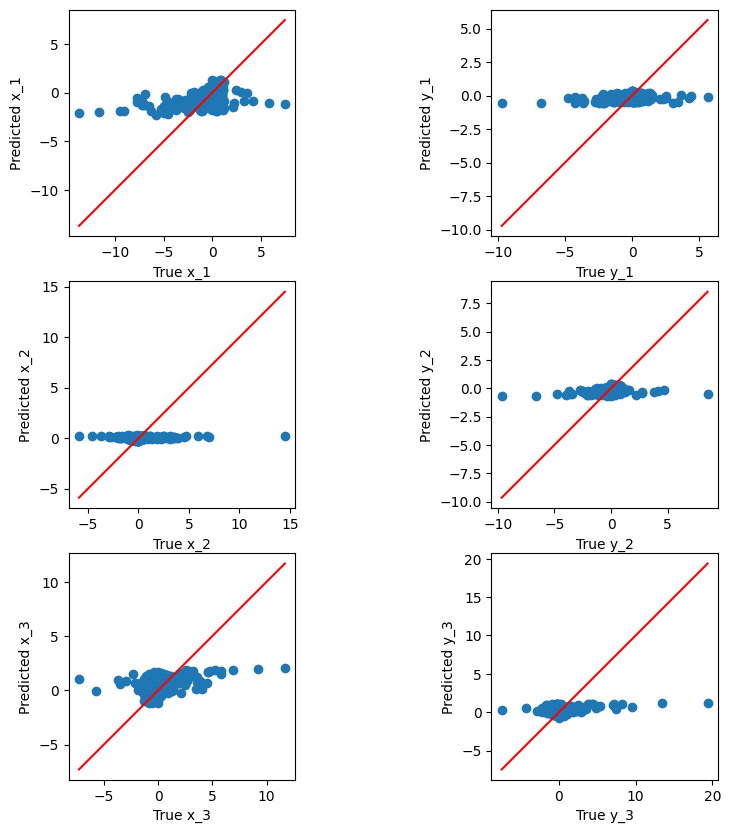

In [97]:
plot_y_yhat(output_validation.to_numpy(), pd.DataFrame(y_hat).to_numpy())


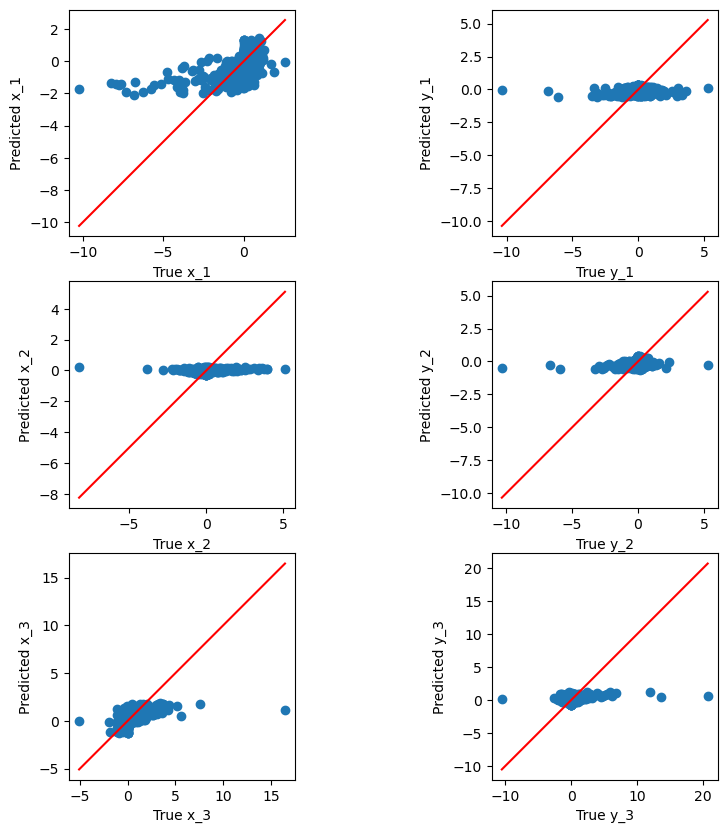

In [22]:
plot_y_yhat(output_validation.to_numpy(), pd.DataFrame(y_hat).to_numpy())

# Task 2: Nonlinear models on the data — the Polynomial Regression model
## Task 2.1 Development

In [23]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error

def validate_poly_regression(X_train, y_train, X_val, y_val, regressor=None, degrees=range(1,10), max_features=None):
    
    best_rsme = 1000
    best_degree = 0
    train_scores = []
    validation_scores = []
    n_features_list = []

    for d in degrees:
        #print("Degree ", d)

        pipe_d_degree= Pipeline(
    [       ('preprocessor', PolynomialFeatures(degree=d)),
            ('model', RidgeCV(alphas=np.logspace(-6, 6, 13)))
    ])

        pipe_d_degree.fit(X_train, y_train)

        n_features = pipe_d_degree.named_steps['preprocessor'].n_output_features_
        n_features_list.append(n_features)

        y_train_predict = pipe_d_degree.predict(X_train)
        y_val_predict = pipe_d_degree.predict(X_val)


        train_error = root_mean_squared_error(y_train, y_train_predict)
        #print("Train RMSE:", train_error)

        val_error = root_mean_squared_error(y_val, y_val_predict)
        #print("Test RMSE:", val_error)

        if val_error < best_rsme:
            best_rsme = val_error
            best_degree = d

        train_scores.append(train_error)
        validation_scores.append(val_error)

    return train_scores, validation_scores, best_rsme, best_degree, n_features_list

In [ ]:
degrees=range(1,10)
degree_scores = {d: {'train_scores': [], 'test_scores': []} for d in degrees}
best_rsmes = []
best_degrees = []

for _ in range(10):

    sample_train_set = train_set.sample(frac=0.01)
    sample_input_train = sample_train_set[["t","x_1_init", "y_1_init", "x_2_init", "y_2_init", "x_3_init", "y_3_init"]]
    sample_output_train = sample_train_set[["x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]]
    
    train_scores, validation_scores, best_rsme, best_degree, n_features_list = validate_poly_regression(sample_input_train, sample_output_train, input_validation, output_validation)

    best_rsmes.append(best_rsme)
    best_degrees.append(best_degree)

    for d in degrees:
        degree_scores[d]['train_scores'].append(train_scores[d-1])
        degree_scores[d]['test_scores'].append(validation_scores[d-1])

# Save best RMSEs and degrees to CSV
df_best = pd.DataFrame({
    'best_degree': best_degrees,
    'best_rsme': best_rsmes
    
})
df_best.to_csv('./output/csv/PR_best_rsme_degrees.csv', index=False)

In [ ]:
import matplotlib.pyplot as plt

# Create bin edges so that each bar is centered on its respective integer
bin_edges = [i - 0.5 for i in range(1, len(degrees) + 2)]  # Create bin edges

plt.hist(best_degrees, bins=bin_edges, color='blue', edgecolor='black')

plt.xticks(range(1, len(degrees) + 1))

plt.title('Distribution of Selected Polynomial Degrees')
plt.xlabel('Degree')
plt.ylabel('Frequency')

plt.show()

In [ ]:
plt.plot(best_rsmes, color='orange')
plt.title('RMSE throughout 10 runs')
plt.xlabel('# of run')
plt.ylabel('RMSE')
plt.show()

### Train with the best-degree model


In [ ]:
best_degree_ever = max(set(best_degrees), key=best_degrees.count)

print("Best degree", best_degree_ever)

pipe_best_degree= Pipeline(
[       ('preprocessor', PolynomialFeatures(degree=best_degree_ever)),
        ('model', RidgeCV(alphas=np.logspace(-6, 6, 13)))
])

pipe_best_degree.fit(input_train, output_train)

output_train_predict = pipe_best_degree.predict(input_train)
output_val_predict = pipe_best_degree.predict(input_validation)

train_error = root_mean_squared_error(output_train, output_train_predict)
print("Train RMSE:", train_error)

val_error = root_mean_squared_error(output_validation, output_val_predict)
print("Validation RMSE:", val_error)

## Task 2.2 Evaluation

In [ ]:
plot_y_yhat(output_validation.to_numpy(), pd.DataFrame(output_val_predict).to_numpy())

# Task 3: Feature Engineering
## Task 3.1 Removing variables

## Task 3.2 Evaluation of Variable Reduction

## Task 3.3 Adding Variables

## Task 3.4 Evaluation of Variable Augmentation

# Task 4: Nonparamentric Model — the k-Nearest Neighbors Regressor
## Task 4.1 Development

In [66]:
    
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import root_mean_squared_error
import time

In [76]:
analytics = []
def validate_knn_regression(X_train, y_train, X_val, y_val, k=range(1,15)):
    for n_neighbors in k:
        pipe = Pipeline(
            [
                    ('scaling', StandardScaler()), 
                    ("model", KNeighborsRegressor(n_neighbors=n_neighbors))
            ])
        start_time = time.time()

        pipe.fit(X_train, y_train)
        y_hat = pipe.predict(X_val)
        elapsed_time = time.time() - start_time
        rmse = root_mean_squared_error(y_hat, y_val)

        print(f'k: {n_neighbors} with RMSE: {rmse}, time: {elapsed_time}')
        analytics.append([n_neighbors, rmse, elapsed_time])

validate_knn_regression(input_train, output_train, input_validation, output_validation, k=range(1,15))

k: 1 with RMSE: 0.7275930517224182, time: 2.790147066116333
k: 2 with RMSE: 0.7233738255959837, time: 2.8484179973602295
k: 3 with RMSE: 0.7206474721144419, time: 2.847382068634033
k: 4 with RMSE: 0.6934124057332598, time: 2.8576979637145996
k: 5 with RMSE: 0.6915715246287238, time: 2.8991799354553223
k: 6 with RMSE: 0.6922431032162351, time: 3.056864023208618
k: 7 with RMSE: 0.6925632612786282, time: 3.035612106323242
k: 8 with RMSE: 0.6797055506534827, time: 3.143187999725342
k: 9 with RMSE: 0.6647260732938246, time: 3.1760711669921875
k: 10 with RMSE: 0.6471130779003905, time: 3.2951836585998535
k: 11 with RMSE: 0.6324206463260567, time: 3.649298906326294
k: 12 with RMSE: 0.6248247012326966, time: 3.5603537559509277
k: 13 with RMSE: 0.6228277615325641, time: 3.7334840297698975
k: 14 with RMSE: 0.6298599839081773, time: 4.009287357330322
k: 15 with RMSE: 0.6323339090461143, time: 3.97670316696167
k: 16 with RMSE: 0.6296166883963393, time: 3.814807891845703
k: 17 with RMSE: 0.62619774

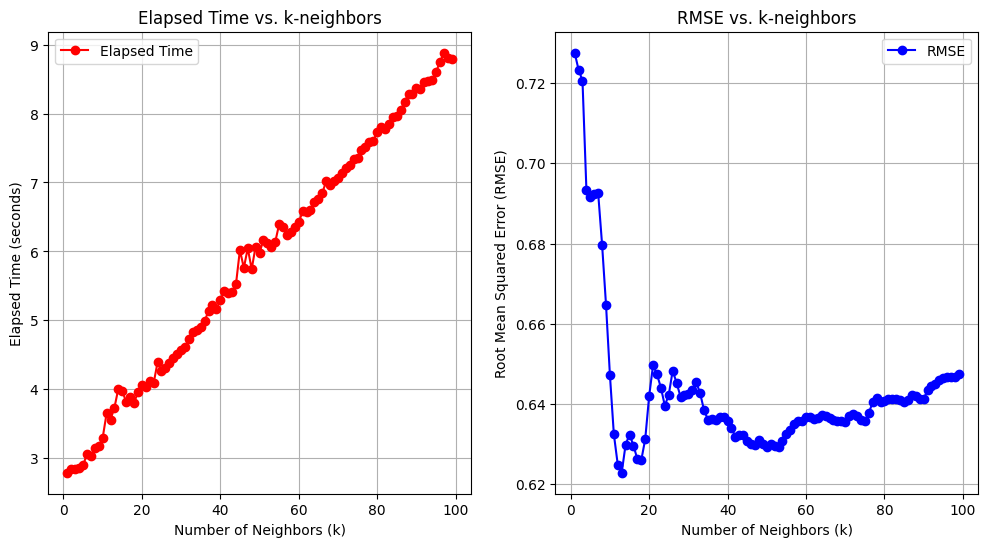

In [77]:
# Extract data for plotting
k_values = [item[0] for item in analytics]
rmse_values = [item[1] for item in analytics]
time_values = [item[2] for item in analytics]

# Create a figure with subplots
plt.figure(figsize=(12, 6))

# Plot elapsed time vs. k-neighbors
plt.subplot(1, 2, 1)
plt.plot(k_values, time_values, marker='o', linestyle='-', color='r', label='Elapsed Time')
plt.title('Elapsed Time vs. k-neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Elapsed Time (seconds)')
plt.grid(True)
plt.legend()

# Plot RMSE vs. k-neighbors
plt.subplot(1, 2, 2)
plt.plot(k_values, rmse_values, marker='o', linestyle='-', color='b', label='RMSE')
plt.title('RMSE vs. k-neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.grid(True)
plt.legend()
plt.savefig('knn'+'.pdf')
plt.show()

## Task 4.2 Evaluation

# Task 5 [Optional]